In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss


plt.rcParams["figure.figsize"] = (15,5)

In [92]:
def plot_acf_pacf_functions(df: pd.DataFrame, feature: str):
    
    '''FUncion para hacer un grafico de la funcion de autocorrelacion (ACF) y autoco'''
    # Import Data
    # df = pd.read_csv('AirPassengers.csv')
    # Draw Plot
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
    plot_acf(df[feature].fillna(method='ffill').tolist(), ax=ax1, lags=50)
    plot_pacf(df[feature].fillna(method='ffill').tolist(), ax=ax2, lags=20)

    # Decorate
    # lighten the borders
    ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
    ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
    ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
    ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)
    
    # font size of tick labels
    ax1.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='both', labelsize=12)
    ax1.set_title(feature + '- ACF')
    ax2.set_title(feature + ' - PACF')

    plt.show()

# 0. Carga de datos

In [111]:
data = pd.read_csv('Eolica.csv')
data = data.set_index(pd.DatetimeIndex(data['Date']))
data.index = pd.to_datetime(data.Date)
data.drop(['Date'], axis=1, inplace=True)
data.head()

,WindSpeed,WindDirection,WindEnergy
Date,,,
2016-01-01,12.96,190.0,280606.59
2016-02-01,10.68,217.0,181981.12
2016-03-01,16.69,223.0,329470.87
2016-04-01,11.35,250.0,216707.38
2016-05-01,12.72,261.0,204859.99


Se comprueba si hay valores perdidos

In [112]:
data.isnull().sum()

WindSpeed        6
WindDirection    6
WindEnergy       8
dtype: int64

Se observa que tenemos datos perdidos. Se rellenan interpolando linealmente para evitar errores en los modelos y métodos de análisis.

In [113]:
data = data.interpolate(method='linear')

# 1. Análisis de la serie temporal

## 1.1 Gráfico de energía respecto del tiempo

<AxesSubplot:xlabel='Date'>

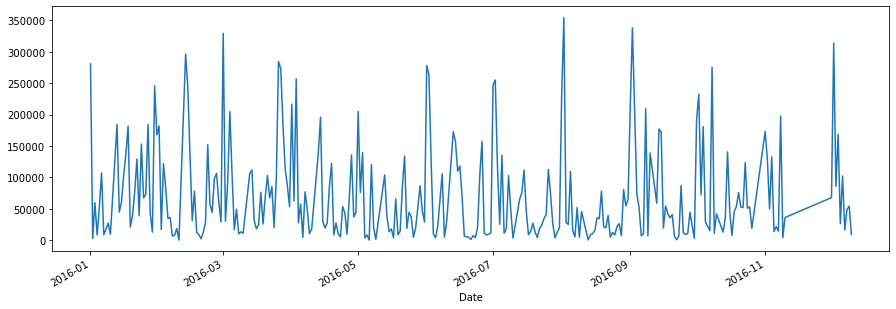

In [154]:
data.WindEnergy[:300].plot(figsize=(15, 5))

Se aprecia una serie no estacionaria ya que el valor medio cambia a lo largo del tiempo.

# 1.2 Descomposición en Season, Trend, Noise

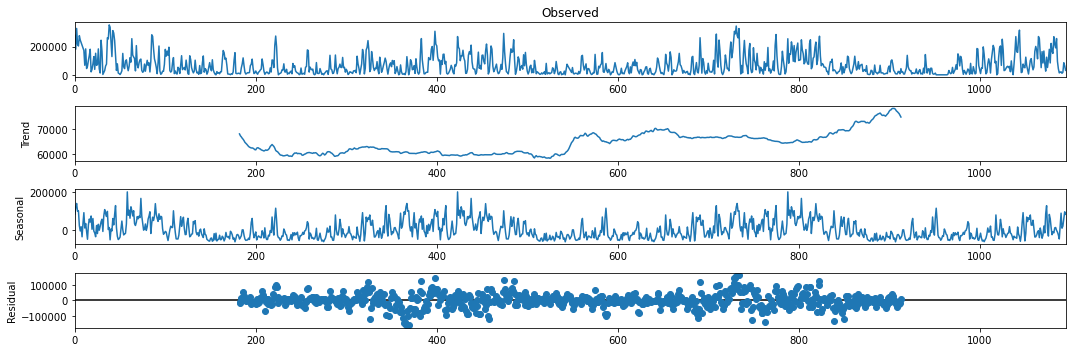

In [203]:
result = seasonal_decompose(data.WindEnergy.values, period=365)
result.plot();

In [204]:
stat, p = adfuller(data.WindEnergy.values)[:2]
print(stat, p)

-4.142391947640378 0.0008235295304596197


In [209]:
stat, p, _,_ = kpss(data.WindEnergy.values, regression='ct')
print(stat, p)

0.16141525563169562 0.037153953640253645


# 1.3 Autocorrelación 

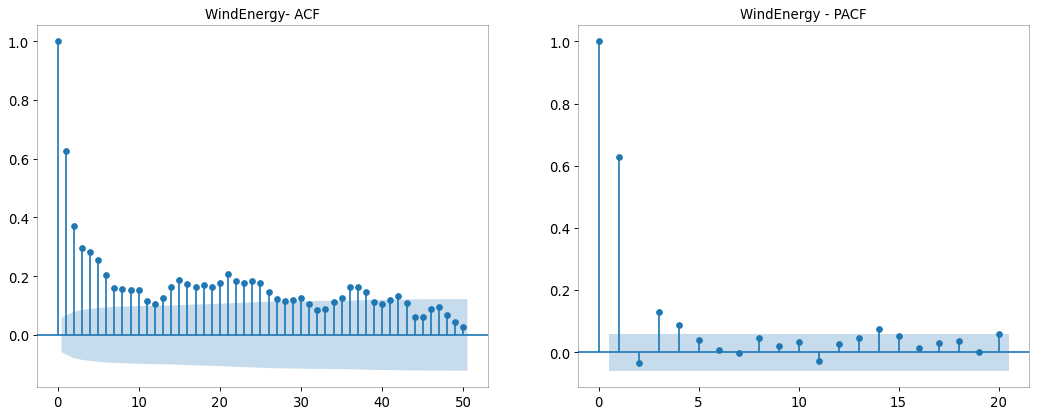

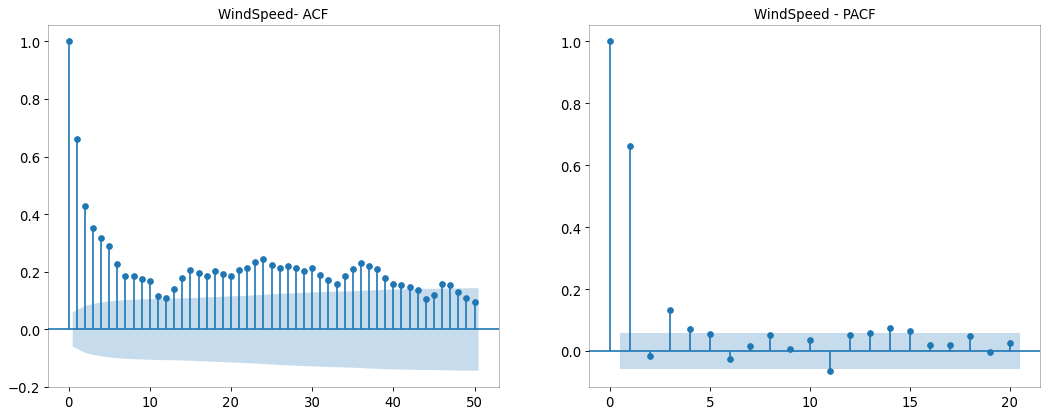

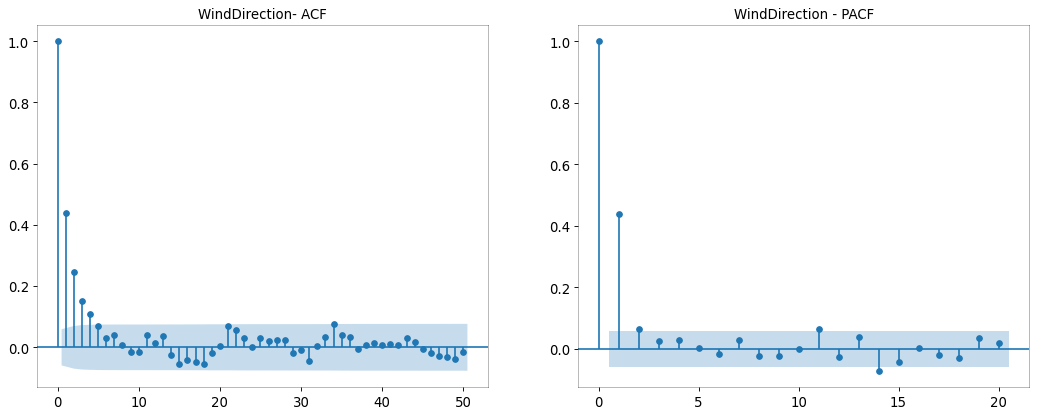

In [210]:
plot_acf_pacf_functions(data, 'WindEnergy')
plot_acf_pacf_functions(data, 'WindSpeed')
plot_acf_pacf_functions(data, 'WindDirection')